In [1]:
import torch
from torch import nn
import csv
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
path = './data'
with open(os.path.join(path, 'pendigits.tra'), 'r') as fp:
    data = np.array(list(csv.reader(fp)))

In [3]:
len(data[0])

17

In [4]:
len(data[:, :-1])

7494

### DataLoader

In [5]:
class PendigitsDataset(Dataset):
    def __init__(self, filename, mode='train'):
        self.mode = mode
        path = './data'
        with open(os.path.join(path, filename), 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data, dtype=np.float32)
        
        features = data[:, :-1]
        targets = data[:, -1]
        
        if mode == 'test':
            self.features = torch.FloatTensor(features)
            self.targets = torch.FloatTensor(targets)
        else:
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 8 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 8 == 0]
            
            self.features = torch.FloatTensor(features[indices])
            self.targets = torch.FloatTensor(targets[indices])
      
    def __getitem__(self, index):
        return self.features[index], self.targets[index].long()
    
    def __len__(self):
        return len(self.features)

In [6]:
train_dataset= PendigitsDataset('pendigits.tra', 'train')
valid_dataset = PendigitsDataset('pendigits.tra', 'dev')
test_dataset = PendigitsDataset('pendigits.tes', 'test')

In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
for X, y in train_loader:
    print(X, y)
    break

tensor([[ 53., 100.,  24.,  ...,  23.,  37.,   0.],
        [ 97., 100.,  43.,  ...,  36.,   0.,   5.],
        [  0.,  95.,  36.,  ...,  34., 100.,  39.],
        ...,
        [ 42.,  79.,  45.,  ...,  10., 100.,   0.],
        [100., 100.,  66.,  ...,  50.,   5.,  46.],
        [100., 100.,  47.,  ...,  25.,  26.,  25.]]) tensor([4, 6, 7, 3, 2, 5, 7, 4, 9, 9, 1, 2, 0, 3, 8, 3, 7, 8, 6, 6, 0, 9, 4, 1,
        9, 9, 7, 6, 0, 6, 3, 5, 2, 6, 4, 2, 2, 7, 6, 8, 0, 1, 2, 1, 0, 5, 5, 2,
        0, 5, 1, 7, 2, 6, 3, 6, 0, 5, 0, 6, 7, 2, 6, 6])


### 网络架构

In [9]:
class Linear(nn.Module):
    def __init__(self, input_dim=16, output_dim=10):
        super(Linear, self).__init__()
        self.layer = nn.Linear(input_dim, output_dim)
        
    def forward(self, X):
        X = X.type_as(self.layer.bias)
        return self.layer(X)
    
    def save(self):
        if not os.path.exists('./res'):
            os.makedir('./res')
        torch.save(self.state_dict(), './res/linear.pth')

In [10]:
class OnehiddenMLP(nn.Module):
    def __init__(self, input_dim=16, output_dim=10, hidden_dim=32):
        super(OnehiddenMLP, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU())
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, X):
        X = X.type_as(self.layer2.bias)
        X = self.layer1(X)
        return self.layer2(X)
    
    def save(self):
        if not os.path.exists('./res'):
            os.makedir('./res')
        torch.save(self.state_dict(), './res/one_hidden_mlp.pth')

In [11]:
class MLP(nn.Module):
    def __init__(self, input_dim=16, output_dim=10):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.BatchNorm1d(64),
                nn.ReLU())
        self.layer2 = nn.Sequential(
                nn.Linear(64, 32),
                nn.BatchNorm1d(32),
                nn.ReLU())
        self.layer3 = nn.Sequential(
                nn.Linear(32, 16),
                nn.BatchNorm1d(16),
                nn.ReLU())
        self.layer4 = nn.Linear(16, output_dim)
        
    def forward(self, X):
        X = X.type_as(self.layer4.bias)
        X = self.layer1(X)
        X = self.layer2(X)
        X = self.layer3(X)
        return self.layer4(X)
    
    def save(self):
        if not os.path.exists('./res'):
            os.makedir('./res')
        torch.save(self.state_dict(), './res/mlp.pth')

### 训练

In [55]:
def train(model, train_loader, valid_loader, num_epoches, lr, wd, device='cpu'):
    train_loss, dev_loss = [], []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    #optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=wd)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epoches):
        print('epoch', epoch , end=' ')
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            pred_y = model(X)
            l = loss(input=pred_y, target=y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_loss.append(l.detach().cpu().item())
        dev_loss.append(dev(model, valid_loader, loss, device))
        print('train_loss: {:.2f}, dev_loss: {:.2f}'.format(train_loss[-1], dev_loss[-1]))
    return train_loss, dev_loss

def dev(model, valid_loader, loss, device):
    model.eval()
    correct = 0 
    total_loss = 0
    cnt = 0
    for X, y in valid_loader:
        X, y  = X.to(device), y.to(device)
        with torch.no_grad():
            pred_y = model(X)
            l = loss(input=pred_y, target=y)
            total_loss += l.detach().cpu().item()
            correct += np.sum((torch.argmax(pred_y, dim=1) == y).numpy())
            cnt += 1
    print('dev accurate: {:.2f}%%'.format(correct/len(valid_loader.dataset)*100), end=' ')
    return total_loss / cnt

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model1 = Linear().to(device)

In [22]:
train_loss1, valid_loss1 = train(model1, train_loader, valid_loader, 100, 1e-2, 1e-4,device)

epoch 0 dev accurate: 83.88%% train_loss: 0.52, dev_loss: 1.12
epoch 1 dev accurate: 85.59%% train_loss: 0.45, dev_loss: 0.72
epoch 2 dev accurate: 85.70%% train_loss: 0.22, dev_loss: 0.59
epoch 3 dev accurate: 85.91%% train_loss: 0.08, dev_loss: 0.60
epoch 4 dev accurate: 90.07%% train_loss: 0.30, dev_loss: 0.52
epoch 5 dev accurate: 90.72%% train_loss: 0.38, dev_loss: 0.48
epoch 6 dev accurate: 90.39%% train_loss: 0.77, dev_loss: 0.44
epoch 7 dev accurate: 89.65%% train_loss: 0.68, dev_loss: 0.50
epoch 8 dev accurate: 87.94%% train_loss: 0.58, dev_loss: 0.70
epoch 9 dev accurate: 89.65%% train_loss: 0.00, dev_loss: 0.55
epoch 10 dev accurate: 86.55%% train_loss: 0.49, dev_loss: 0.75
epoch 11 dev accurate: 87.51%% train_loss: 0.40, dev_loss: 0.54
epoch 12 dev accurate: 89.54%% train_loss: 2.09, dev_loss: 0.72
epoch 13 dev accurate: 90.93%% train_loss: 0.59, dev_loss: 0.60
epoch 14 dev accurate: 90.29%% train_loss: 0.08, dev_loss: 0.55
epoch 15 dev accurate: 87.41%% train_loss: 0.24, d

In [42]:
model2 = OnehiddenMLP().to(device)
train_loss2, valid_loss2 = train(model2, train_loader, valid_loader, 100, 1e-2, 1e-4,device)

epoch 0 dev accurate: 95.62%% train_loss: 0.11, dev_loss: 0.13
epoch 1 dev accurate: 95.41%% train_loss: 0.08, dev_loss: 0.14
epoch 2 dev accurate: 98.83%% train_loss: 0.04, dev_loss: 0.05
epoch 3 dev accurate: 98.08%% train_loss: 0.07, dev_loss: 0.06
epoch 4 dev accurate: 97.55%% train_loss: 0.22, dev_loss: 0.08
epoch 5 dev accurate: 98.29%% train_loss: 0.01, dev_loss: 0.05
epoch 6 dev accurate: 96.91%% train_loss: 0.33, dev_loss: 0.09
epoch 7 dev accurate: 94.56%% train_loss: 0.08, dev_loss: 0.18
epoch 8 dev accurate: 98.19%% train_loss: 0.02, dev_loss: 0.05
epoch 9 dev accurate: 97.65%% train_loss: 0.04, dev_loss: 0.07
epoch 10 dev accurate: 98.40%% train_loss: 0.03, dev_loss: 0.05
epoch 11 dev accurate: 97.97%% train_loss: 0.08, dev_loss: 0.06
epoch 12 dev accurate: 97.65%% train_loss: 0.18, dev_loss: 0.07
epoch 13 dev accurate: 98.61%% train_loss: 0.12, dev_loss: 0.05
epoch 14 dev accurate: 99.04%% train_loss: 0.01, dev_loss: 0.03
epoch 15 dev accurate: 99.47%% train_loss: 0.00, d

In [56]:
model3 = MLP().to(device)
train_loss3, valid_loss3 = train(model3, train_loader, valid_loader, 100, 1e-2, 1e-4,device)

epoch 0 dev accurate: 95.73%% train_loss: 0.17, dev_loss: 0.18
epoch 1 dev accurate: 97.23%% train_loss: 0.13, dev_loss: 0.08
epoch 2 dev accurate: 99.15%% train_loss: 0.13, dev_loss: 0.03
epoch 3 dev accurate: 98.40%% train_loss: 0.07, dev_loss: 0.06
epoch 4 dev accurate: 99.04%% train_loss: 0.42, dev_loss: 0.04
epoch 5 dev accurate: 98.40%% train_loss: 0.26, dev_loss: 0.05
epoch 6 dev accurate: 99.15%% train_loss: 0.01, dev_loss: 0.02
epoch 7 dev accurate: 98.40%% train_loss: 0.04, dev_loss: 0.04
epoch 8 dev accurate: 98.29%% train_loss: 0.06, dev_loss: 0.06
epoch 9 dev accurate: 99.68%% train_loss: 0.02, dev_loss: 0.02
epoch 10 dev accurate: 99.36%% train_loss: 0.02, dev_loss: 0.03
epoch 11 dev accurate: 99.36%% train_loss: 0.02, dev_loss: 0.02
epoch 12 dev accurate: 98.83%% train_loss: 0.21, dev_loss: 0.04
epoch 13 dev accurate: 99.57%% train_loss: 0.00, dev_loss: 0.02
epoch 14 dev accurate: 99.68%% train_loss: 0.02, dev_loss: 0.01
epoch 15 dev accurate: 99.36%% train_loss: 0.04, d

### Predict

In [61]:
correct = 0
for X, y in test_loader:
    correct += np.sum((torch.argmax(model1(X), dim=1)==y).numpy())
accu = correct/len(test_loader.dataset)*100
print("test_accuracy: {:.2f}%".format(accu))

test_accuracy: 84.93%


In [60]:
correct = 0
for X, y in test_loader:
    correct += np.sum((torch.argmax(model2(X), dim=1)==y).numpy())
accu = correct/len(test_loader.dataset)*100
print("test_accuracy: {:.2f}%".format(accu))
#model2.save()

test_accuracy: 96.31%


In [58]:
correct = 0
for X, y in test_loader:
    correct += np.sum((torch.argmax(model3(X), dim=1)==y).numpy())
accu = correct/len(test_loader.dataset)*100
print("test_accuracy: {:.2f}%".format(accu))
#model3.save()

test_accuracy: 97.68%


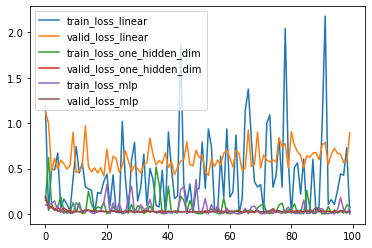

In [47]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
plt.plot(train_loss1, label='train_loss_linear')
plt.plot(valid_loss1, label='valid_loss_linear')
plt.plot(train_loss2, label='train_loss_one_hidden_dim')
plt.plot(valid_loss2, label='valid_loss_one_hidden_dim')
plt.plot(train_loss3, label='train_loss_mlp')
plt.plot(valid_loss3, label='valid_loss_mlp')
plt.legend()
plt.show()